In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.svm import LinearSVC
import joblib
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import random
from tensorflow import keras

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
  print('use: GPU')
else:
  print('use: CPU')

use: CPU


In [8]:
DATASET_DIR = "./dataset/augement"
CATEGORIES = ["Avicii", "KienTrung", "MaiTue", "MartinGarrix"]

In [9]:
### load dataset
training_data = []
def create_training_data() -> None:
  for category in CATEGORIES:
    path = os.path.join(DATASET_DIR, category)
    label = category
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        training_data.append([img_array, label])
      except Exception as e:
        pass
      
create_training_data()
random.shuffle(training_data)

print(len(training_data))

1400


In [10]:
recognizer = cv2.FaceRecognizerSF.create("./model/face_recognition_sface_2021dec.onnx","")
embedded = np.zeros((len(training_data), 128))

for i, data in enumerate(training_data):
  face_feature = recognizer.feature(data[0])
  embedded[i] = face_feature

targets = np.array([data[1] for data in training_data])
encoder = LabelEncoder()
encoder.fit(targets)


LabelEncoder()

In [11]:
x_train = embedded
y_train = encoder.transform(targets)
print(x_train.shape)
print(y_train.shape)

(1400, 128)
(1400,)


In [12]:
x_test = x_train[int(0.9 * len(training_data)):,:]
y_test = y_train[int(0.9 * len(training_data)):]
print(x_test.shape)
print(y_test.shape)

(140, 128)
(140,)


In [13]:
svc = LinearSVC()
svc.fit(x_train, y_train)
acc_svc = accuracy_score(y_test, svc.predict(x_test))
print('SVM accuracy: %.6f' % acc_svc)
joblib.dump(svc,'./model/face_recog_svc.pkl')

SVM accuracy: 1.000000


['./model/face_recog_svc.pkl']

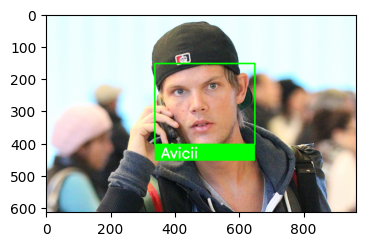

In [50]:
model_svc = joblib.load('./model/face_recog_svc.pkl')
mydict = ['Avicii',  'MartinGarrix']

detector = cv2.FaceDetectorYN.create(
  'model/face_detection_yunet_2022mar.onnx', "",
  (320, 320), 0.9, 0.3, 5000
)
recognizer = cv2.FaceRecognizerSF.create(
  "./model/face_recognition_sface_2021dec.onnx",""
)

def debug_imshow(image):
  fig = plt.figure(figsize=(4, 3), dpi=100)
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()


## test image
image_path = 'static/avicii_thumb.jpg'
image = cv2.imread(image_path)
img = cv2.resize(image, (320, 320)) 

_, faces = detector.detect(img)

img_result = image.copy()

if faces is not None:
  for face in faces:
    x1, y1, w, h = face[:4]
    x1 = x1*(image.shape[1]/320)
    y1 = y1*(image.shape[0]/320)
    w = w*(image.shape[1]/320)
    h = h*(image.shape[0]/320)

    color = (0, 255, 0)
    thickness = 3

    start_point = (int(x1), int(y1))
    end_point = (int(x1+w), int(y1+h))
    img_result = cv2.rectangle(img_result, start_point, end_point, color, thickness)

    cropped_face_img = img_result[start_point[1]:end_point[1], start_point[0]:end_point[0]]
    face_feature = recognizer.feature(cropped_face_img)
    test_predict = svc.predict(face_feature)
    result = mydict[test_predict[0]]

    start_point = (int(x1), int(y1+h))
    end_point = (int(x1+w), int(y1+h+50))
    img_result = cv2.rectangle(img_result, start_point, end_point, color, -1)
    cv2.putText(img_result,result,(int(x1+20), int(y1+h+42)), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 4)
cv2.imwrite('out.jpg', img_result)
debug_imshow(img_result)